In [ ]:
## Ideas

# Sparse Net, optimal net, limited nerons? (drop-out & look at weight connections)

## Can you do specific hypothesis testing with changes in features if you bootstrap distributions

# Reference Paper Formulas

## (1)

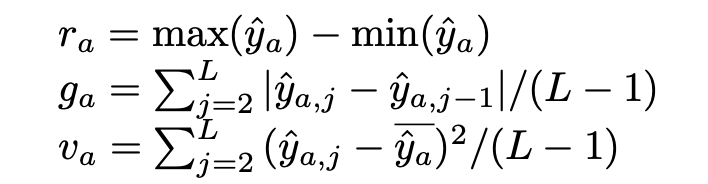

## (2)

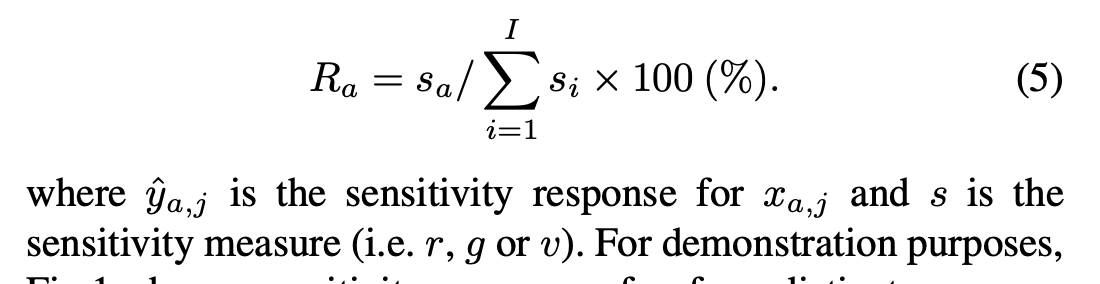

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import tensorboard
%load_ext tensorboard

In [ ]:
path = "https://raw.githubusercontent.com/shrikant-temburwar/Wine-Quality-Dataset/master/winequality-red.csv"
df_r = pd.read_csv(path,delimiter=";")
#df_r['Color'] = 1

path = "https://raw.githubusercontent.com/shrikant-temburwar/Wine-Quality-Dataset/master/winequality-white.csv"
df_w = pd.read_csv(path,delimiter=";")
df_w['Color'] = 0
#df = df_r.append(df_w)
df = df_r

# https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# First Attempt

In [ ]:
def feature_scores(data,target,nodes,plot=False,base=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']
  
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

  history = model.fit(
      X_train.iloc[train_idxs, :], y_train[train_idxs]),
      #validation_split=0.2, 
      verbose = 0,
      epochs=100)
  

  # Only works if validation is on
  if plot == True:
    
    def plot_loss(history):
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.ylim([0, 5])
      plt.xlabel('Epoch')
      plt.ylabel('Error')
      plt.legend()
      plt.grid(True)
    print(plot_loss(history))

  avg_set = X_train.describe().T['mean'].to_numpy()
  stdev = X_train.describe().T['std'].to_numpy()

  info = []
  for idx, i in enumerate(stdev):
    null = np.zeros(stdev.shape[0])
    null[idx] = i
    info.append(null)

  design = []
  for i in range(avg_set.shape[0]):
    null = avg_set + info[i]
    design.append(null)
  
  if base ==True:
    base_pred =[]
    base = model.predict(avg_set.reshape(1,-1))
    null = float(base)
    base_pred.append(null)
    print(base_pred)
    return base_pred
  
  else:
    preds = []
    for i in range(len(design)):
      preds.append(model.predict(design[i].reshape(1,-1)))

    #scores = base - preds
    out = []
    for i in preds:
      null = float(i)
      out.append(null)

    print(out)
    return out
  

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(train_features.shape[1],),activation='relu'))
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

history = model.fit(
    train_features, train_labels,
    validation_split=0.2, verbose = 0,
    epochs=100)

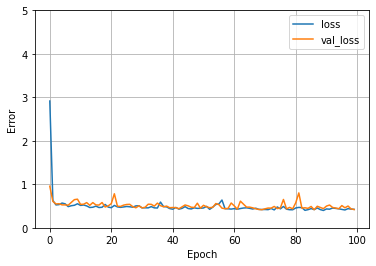

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
# Bootstrap
n = X_train.shape[0]
nbootstraps = np.sqrt(n).astype(int)


avg_set = train_features.describe().T['mean'].to_numpy()
stdev = train_features.describe().T['std'].to_numpy()
# I need pxp matrix where each step includes all zeros except one value, in order
info = []
for idx, i in enumerate(stdev):
  null = np.zeros(stdev.shape[0])
  null[idx] = i
  info.append(null)

# could test for linear & nonlinear effect
# one standard deviation up & down, is it linear?
design = []
for i in range(avg_set.shape[0]):
  null = avg_set + info[i]
  design.append(null)

base = model.predict(avg_set.reshape(1,-1))

preds = []
for i in range(len(design)):
  preds.append(model.predict(design[i].reshape(1,-1)))
  
scores = base - preds
out = []
for i in preds:
  null = float(i)
  out.append(null)


# Loop

In [ ]:
# distribution of Base Y Hat
dat_base = pd.DataFrame({
    "Base Predictions": []
})
N = 25
for i in range(N):
  dat_base.loc[len(dat_base), :] = feature_scores(df,'quality',"NA",20,base=True)

In [ ]:
# pH
cols = np.linspace(-1,1,21)
cols = np.delete(cols, 10)
dat = pd.DataFrame(columns = np.round(cols,decimals=4))
N = 25
for i in range(N):
  dat.loc[len(dat), :] = np.concatenate(feature_scores(df,'quality','pH',20,base=False)).reshape(1,-1)

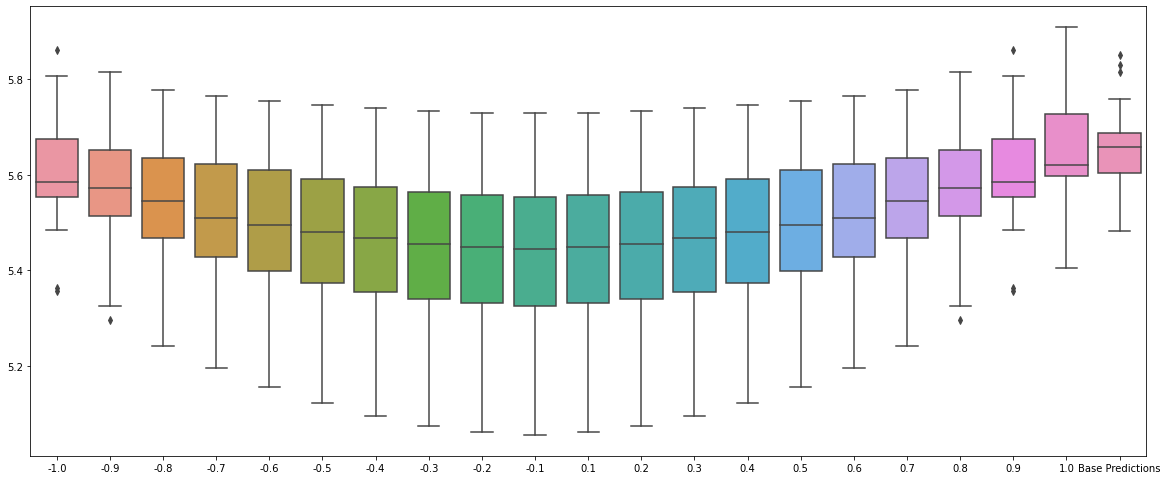

In [ ]:
#pH
#dat.columns = np.round(cols,decimals=4)
info = pd.concat([dat,dat_base],axis=1)
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=info);

In [ ]:
# chlorides
cols = np.linspace(-1,1,21)
cols = np.delete(cols, 10)
dat = pd.DataFrame(columns = np.round(cols,decimals=4))
N = 25
for i in range(N):
  dat.loc[len(dat), :] = np.concatenate(feature_scores(df,'quality','chlorides',20,base=False)).reshape(1,-1)

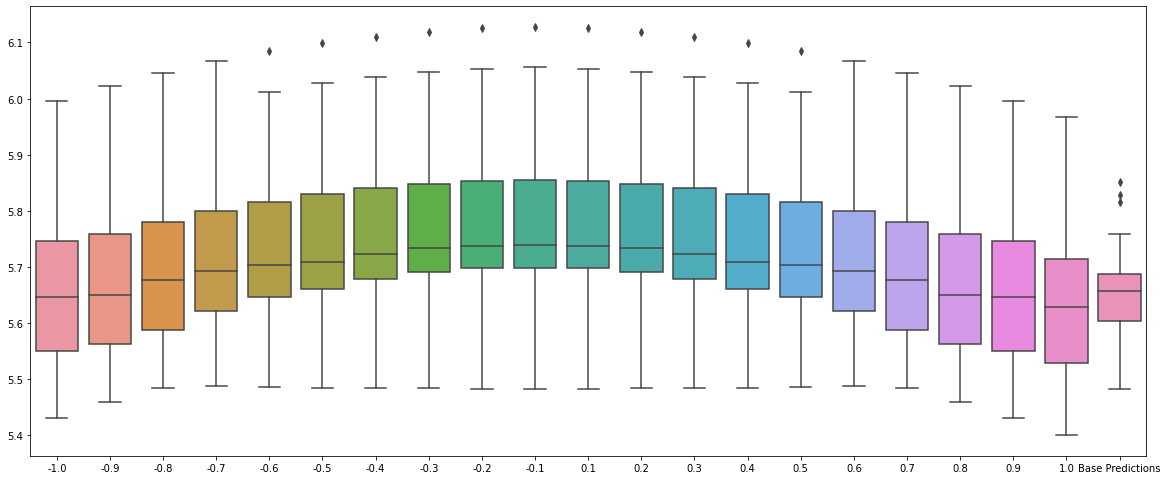

In [ ]:
# chlorides
#dat.columns = np.round(cols,decimals=4)
info = pd.concat([dat,dat_base],axis=1)
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=info);


In [ ]:
# fixed acidity
cols = np.linspace(-1,1,21)
cols = np.delete(cols, 10)
dat = pd.DataFrame(columns = np.round(cols,decimals=4))
N = 25
for i in range(N):
  dat.loc[len(dat), :] = np.concatenate(feature_scores(df,'quality','fixed acidity',20,base=False)).reshape(1,-1)

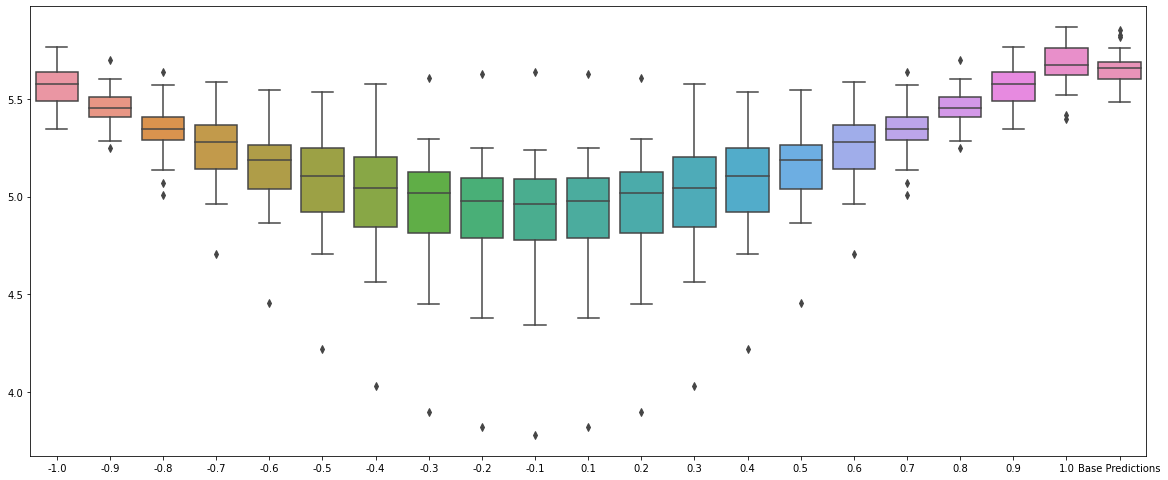

In [ ]:
# fixed acidity
#dat.columns = np.round(cols,decimals=4)
info = pd.concat([dat,dat_base],axis=1)
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=info);


# VEC

In [ ]:
def vec(data,target,nodes,var):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  var_eff = df[f'{var}']
  var_vals = np.round(np.percentile(df[f'{var}'],np.arange(0, 100, 10)),2)
  preds =[]
  print(f"Predict with {var}'s deciles")
  for i in range(len(var_vals)):
    avg_set = X_train.describe().T['mean']
    avg_set[f'{var}'] = var_vals[i]
    avg_set = avg_set.to_numpy()
    mod = model.predict(avg_set.reshape(1,-1))
    null = float(mod)
    preds.append(null)
  return preds, var_vals

In [ ]:
lis, vals = vec(df,'quality',20,'volatile acidity')

Predict with volatile acidity's deciles


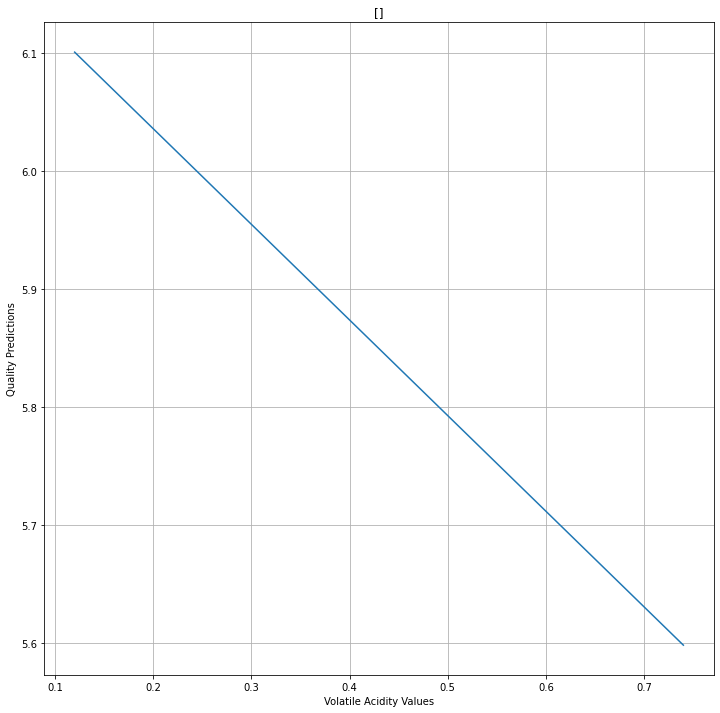

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Volatile Acidity Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

In [ ]:
lis, vals = vec(df,'quality',20,'pH')

Predict with pH's deciles


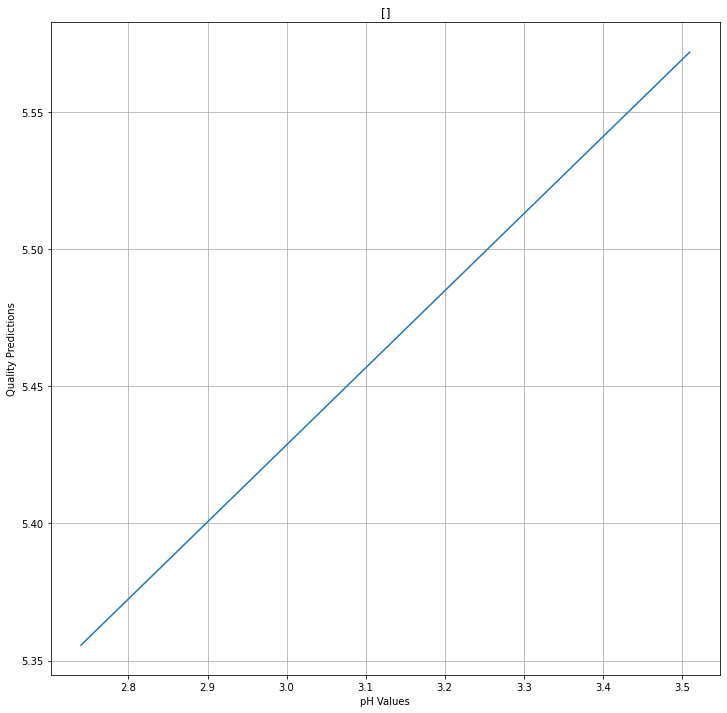

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='pH Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

# VEC with average response

In [ ]:
def vec_ave(data,target,nodes,var):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  
  var_vals = np.round(np.percentile(df[f'{var}'],np.arange(0, 100, 10)),2)
  preds =[]
  print(f"Average Prection with {var}'s deciles") 
  for i in range(len(var_vals)):
    X_train[f'{var}'] = var_vals[i]
    mod = model.predict(X_train.to_numpy())
    null = np.mean(mod)
    preds.append(null)
  return preds, var_vals

In [ ]:
lis,vals = vec_ave(df,'quality',20,'volatile acidity')
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Volatile Acidity Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

In [ ]:
lis,vals = vec_ave(df,'quality',20,'alcohol')
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Alcohol Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

In [ ]:
lis,vals = vec_ave(df,'quality',20,'sulphates')
fig, ax = plt.subplots(1,figsize=(12,12))
ax.plot(vals,lis)
ax.set(xlabel='Sulphate Values', ylabel='Quality Predictions',
       title='[]')
ax.grid()
plt.show();

# VEC with all predictors

In [ ]:
features = df.loc[:, df.columns != 'quality']

def scale(data,center=True):
  df = data.copy()
  if center:
    for i in range(df.shape[1]):
      df.iloc[:,i] = (df.iloc[:,i] - np.mean(df.iloc[:,i])) / np.std(df.iloc[:,i])
    return df
  else:
    for i in range(df.shape[1]):
      df.iloc[:,i] = (df.iloc[:,i] - np.min(df.iloc[:,i])) / (np.max(df.iloc[:,i])- np.min(df.iloc[:,i]))
    return df


def vec_all(data,target,nodes,average=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']
  X_train = scale(X_train,center=False)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  x_axis = np.linspace(0,1,num = 30)
  if average == True:
    frame = pd.DataFrame(0, index=range(len(x_axis)), columns=X_train.columns)
    for i in range(len(x_axis)):
      for j in range(X_train.shape[1]):
        avg_set = X_train.describe().T['mean']
        avg_set[X_train.columns[j]] = x_axis[i]
        avg_set = avg_set.to_numpy()
        mod = model.predict(avg_set.reshape(1,-1))
        frame.iloc[i:i+1,j:j+1] = mod
    return frame

  if average == False:
    frame = pd.DataFrame(0, index=range(len(x_axis)), columns=X_train.columns)
    for i in range(len(x_axis)):
      for j in range(len(X_train.columns)):
        newset = X_train.copy()
        newset[newset.columns[j]] = x_axis[i]
        mod = model.predict(newset.to_numpy())
        null = np.mean(mod)
        frame.iloc[i:i+1,j:j+1] = null
    return frame

In [ ]:
temp = vec_all(df,'quality',20,average=True)

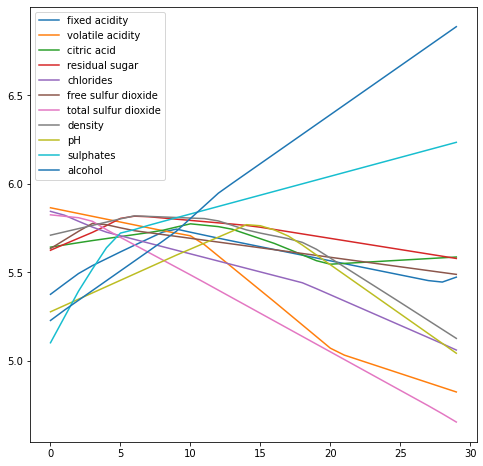

In [ ]:
temp.plot(figsize=(8,8));

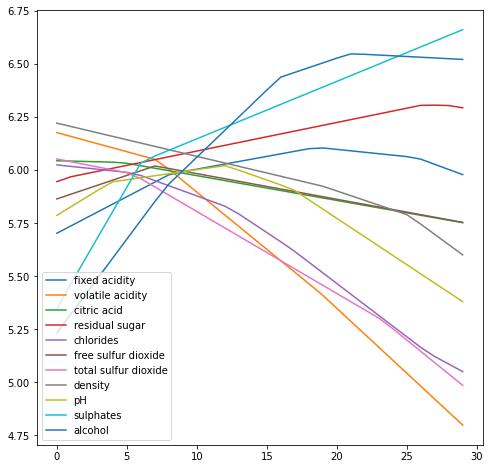

In [ ]:
plot = temp.plot(figsize=(8,8))
fig = plot.get_figure()
fig.savefig("VEC_Using_Average_Vals1.jpg",dpi=300)

In [ ]:
temp = vec_all(df,'quality',20,average=False)

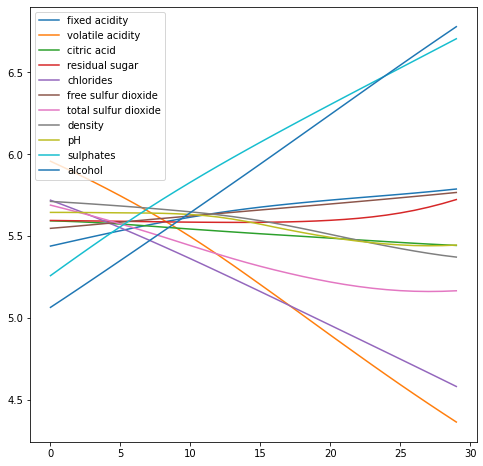

In [ ]:
temp.plot(figsize=(8,8));

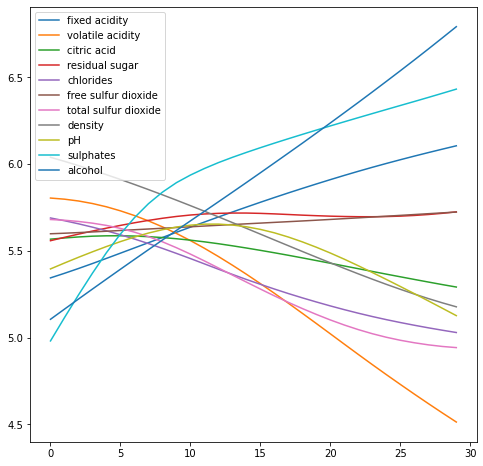

In [ ]:
plot = temp.plot(figsize=(8,8))
fig = plot.get_figure()
fig.savefig("VEC_Change_Whole_Col2.jpg",dpi=300)

# Sensitivity Analysis

In [ ]:
# I need to implement sensitivity analysis for inputs
# sensitivity is sum(y_i - y_bar) / (n-1)
# where at each i the input is shifted across its range
# the authors say the most sensitive variables will be the most important

# the SA x axis is the number of shifts in the input, 1,2,3...,30,31 etc
# the y axis is the variability of the output

# What is y bar? Is is the mean of the actual or the mean of the predictions

In [ ]:
def scale(data,center=True):
  df = data.copy()
  if center:
    for i in range(df.shape[1]):
      df.iloc[:,i] = (df.iloc[:,i] - np.mean(df.iloc[:,i])) / np.std(df.iloc[:,i])
    return df
  else:
    for i in range(df.shape[1]):
      df.iloc[:,i] = (df.iloc[:,i] - np.min(df.iloc[:,i])) / (np.max(df.iloc[:,i])- np.min(df.iloc[:,i]))
    return df


def SA_all(data,target,nodes,num_intvs,average=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']
  X_train = scale(X_train,center=False)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  
  history = model.fit(
      X_train, 
      y_train,
      verbose = 0,
      epochs=100)
  
  intvs = num_intvs
  y_bar = np.mean(y_train)
  if average == True:
    SA = pd.DataFrame(0, index=list(range(2,intvs)), columns=X_train.columns)
    for k in range(2,intvs):
      x_axis = np.linspace(0,1,num = k)
      frame = pd.DataFrame(0, index=range(len(x_axis)), columns=X_train.columns)
      for i in range(len(x_axis)):
        for j in range(X_train.shape[1]):
          avg_set = X_train.describe().T['mean']
          avg_set[X_train.columns[j]] = x_axis[i]
          avg_set = avg_set.to_numpy()
          mod = model.predict(avg_set.reshape(1,-1))
          frame.iloc[i:i+1,j:j+1] = mod
      SA.loc[k] = ((y_bar - frame)**2/len(x_axis)).describe().T['mean']
    return SA

  if average == False:
    SA = pd.DataFrame(0, index=list(range(2,intvs)), columns=X_train.columns)
    for k in range(2,intvs):
      x_axis = np.linspace(0,1,num = k)
      frame = pd.DataFrame(0, index=range(len(x_axis)), columns=X_train.columns)
      for i in range(len(x_axis)):
        for j in range(len(X_train.columns)):
          newset = X_train.copy()
          newset[newset.columns[j]] = x_axis[i]
          mod = model.predict(newset.to_numpy())
          null = np.mean(mod)
          frame.iloc[i:i+1,j:j+1] = null
      SA.loc[k] = ((y_bar - frame)**2/len(x_axis)).describe().T['mean']
    return SA

In [ ]:
temp = SA_all(df,'quality',20,11,average=True)

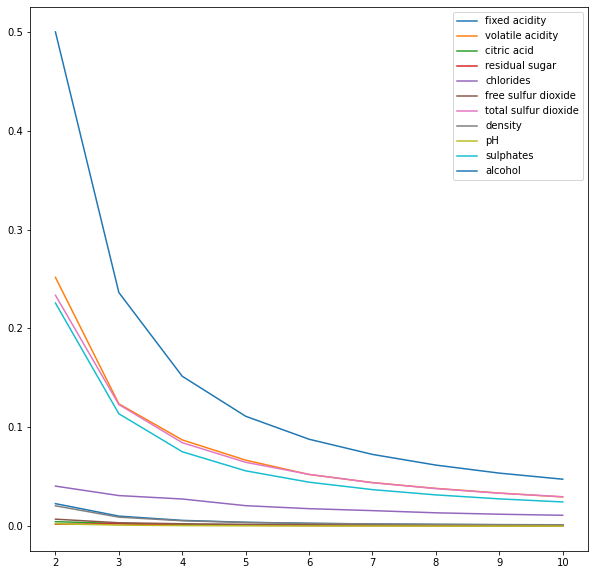

In [ ]:
temp.plot(figsize=(10,10));

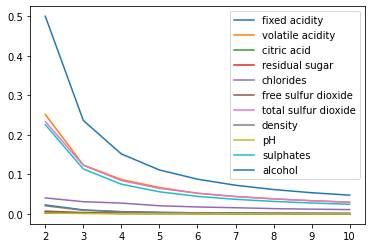

In [ ]:
plot = temp.plot()
fig = plot.get_figure()
fig.savefig("SA_Using_Average_Vals2.jpg",dpi=300)

In [ ]:
temp = SA_all(df,'quality',20,11,average=False)

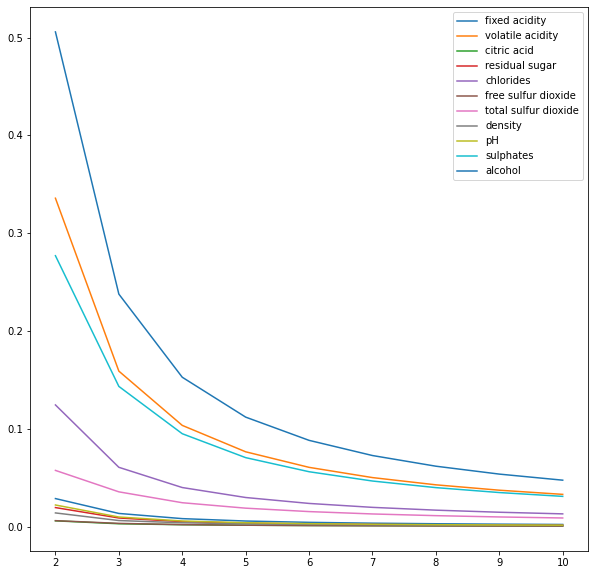

In [ ]:
temp.plot(figsize=(10,10));

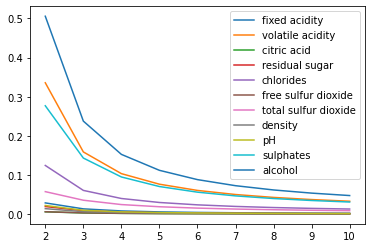

In [ ]:
plot = temp.plot()
fig = plot.get_figure()
fig.savefig("SA_Change_Whole_Col2.jpg",dpi=300)

# Bootstrap

## First Attempt. Only using STDEV

In [ ]:
def feature_scores(data,target,feature,nodes,n_boot,base=False):
  df = data.copy()
  y_train = df[f'{target}']
  X_train = df.loc[:, df.columns != f'{target}']

  # Bootstrap #
  n = n_boot
  train_idxs = np.random.choice(range(X_train.shape[0]), size = n, replace = True)
  #val_idxs = np.array([idx for idx in range(n) if idx not in train_idxs])
  #X_train.iloc[train_idxs,:]
  #y_train[train_idxs]
  ##############

  # Instantiate model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(nodes, input_shape=(X_train.shape[1],),activation='relu'))
  model.add(tf.keras.layers.Dense(nodes,activation = 'relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

  # Fit model
  history = model.fit(
      X_train.iloc[train_idxs, :], 
      y_train[train_idxs],
      verbose = 0,
      epochs=20)

  if base:
    avg_set = X_train.describe().T['mean'].to_numpy()
    base = model.predict(avg_set.reshape(1,-1))
    return float(base)

  else:
    print(f"Fitting {feature} Standard Devation Changes..")
    stdev = X_train.describe().T['std']
    avg_set = X_train.describe().T['mean']
    feat_stdev = stdev[f'{feature}']
    stdevs = feat_stdev*np.linspace(-1,1,21)
    stdevs = np.delete(stdevs, 10)
    feat_preds = []
    for i in range(len(stdevs)):
      print(i)
      avg_set[avg_set.index == f'{feature}'] = avg_set[avg_set.index == f'{feature}'] + stdevs[i]
      predict_set = avg_set.to_numpy()
      feat_preds.append(model.predict(predict_set.reshape(1,-1)))

    return feat_preds


In [ ]:
preds = []
for i in range(100):
  preds.append(feature_scores(df,'quality',None,20,base=True))

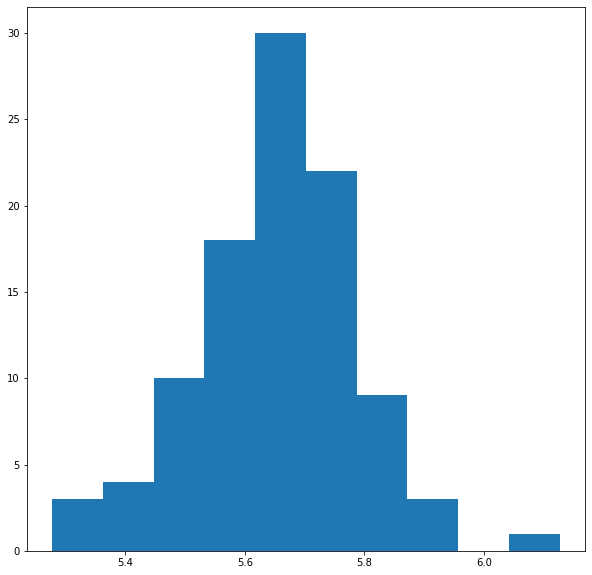

In [ ]:
fig, ax  = plt.subplots(figsize=(10,10))
#ax.plot(preds);
ax.hist(preds);

In [ ]:
X1 = np.random.uniform(0,20,size=10000)
X2 = np.random.uniform(0,4,size=10000)
sig = np.random.normal(0,scale=10,size=10000)
Y = -2 + 3.5*X1 + 2.2*X2+ sig
#fix,ax = plt.subplots(figsize=(8,8))
#ax.hist(sig);

frame = pd.DataFrame({
    "Y" : Y,
    "X1" : X1,
    "X2" : X2
})

idx = np.random.choice(range(1000), size = 1000, replace = False)
samp = frame.iloc[idx,]

In [ ]:
preds = []
for i in range(20):
  preds.append(feature_scores(samp,"Y",None,20,5000,base=True))

(array([2., 0., 1., 3., 1., 4., 1., 2., 4., 2.]),
 array([35.34640884, 35.64834442, 35.95028   , 36.25221558, 36.55415115,
        36.85608673, 37.15802231, 37.45995789, 37.76189346, 38.06382904,
        38.36576462]),
 <a list of 10 Patch objects>)

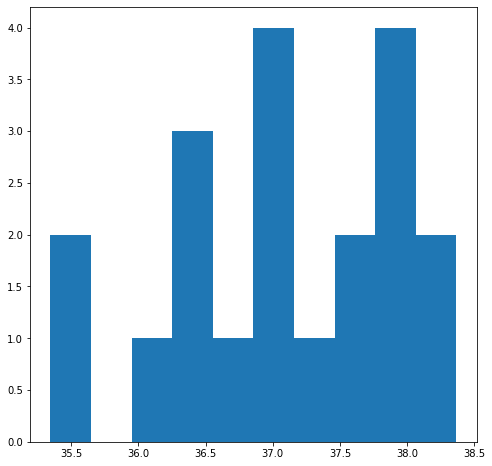

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(preds)
#ax.hist(Y)

# Miscellaneous

In [ ]:
x_axis = np.linspace(0,1,num = 2)
x_axis
for k in range(2,9):
  x_axis = np.linspace(0,1,num = k)
  print(x_axis)

frame = pd.DataFrame(0, index=range(len(x_axis)), columns=features.columns)
frame.iloc[3:3+1,1:1+1] = 1
frame.iloc[4:4+1,2:2+1] = 2
frame.iloc[4:4+1,6:6+1] = 2
frame

SA = pd.DataFrame(0, index=list(range(2,9)), columns=features.columns)
frame.describe().T['mean']
k = 2
y_bar = 2

#SA.loc[k]


[0. 1.]
[0.  0.5 1. ]
[0.         0.33333333 0.66666667 1.        ]
[0.   0.25 0.5  0.75 1.  ]
[0.  0.2 0.4 0.6 0.8 1. ]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]


fixed acidity           0.285714
volatile acidity        0.267857
citric acid             0.250000
residual sugar          0.285714
chlorides               0.285714
free sulfur dioxide     0.285714
total sulfur dioxide    0.250000
density                 0.285714
pH                      0.285714
sulphates               0.285714
alcohol                 0.285714
Name: mean, dtype: float64

In [ ]:
!rm -rf ./logs/ 
target='quality'
y_train = df[f'{target}']
X_train = df.loc[:, df.columns != f'{target}']


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32,input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(10,activation='relu'))
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipvalue=0.5)
model.compile(optimizer=sgd,loss='mean_squared_error')

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(X_train,y_train,
          epochs=5,
          callbacks=[tensorboard_callback])
model.summary()

Epoch 1/5
50/50 [==============================] - 0s 3ms/step - loss: 34.9392
Epoch 2/5
50/50 [==============================] - 0s 1ms/step - loss: 35.4574
Epoch 3/5
50/50 [==============================] - 0s 1ms/step - loss: 32.7996
Epoch 4/5
50/50 [==============================] - 0s 1ms/step - loss: 32.5768
Epoch 5/5
50/50 [==============================] - 0s 1ms/step - loss: 32.7071
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                384       
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                330       
Total params: 1,770
Trainable params: 1,770
Non-trainable params: 0
____________________________________________________

In [ ]:
model.layers[0].get_weights()[0]

In [ ]:
%tensorboard --logdir logs

In [ ]:
x_axis = np.linspace(1,1000,num = 10001)
x_axis

def cos_squish(x):
  return 1 + np.cos(x + (3*np.pi)/2)

temp = cos_squish(x_axis)
print(x_axis)
print(temp)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(temp)

In [ ]:
x_axis = np.linspace(0,1,num = 30)
frame = pd.DataFrame(0, index=range(len(x_axis)), columns=features.columns)

for i in range(len(x_axis)):
  for j in range(len(features.columns)):
    frame.iloc[i:i+1,j:j+1] = 2
features.loc[features.columns[0]] = x_axis[1]
features

frame.iloc[1:2,2:3] = 3
frame

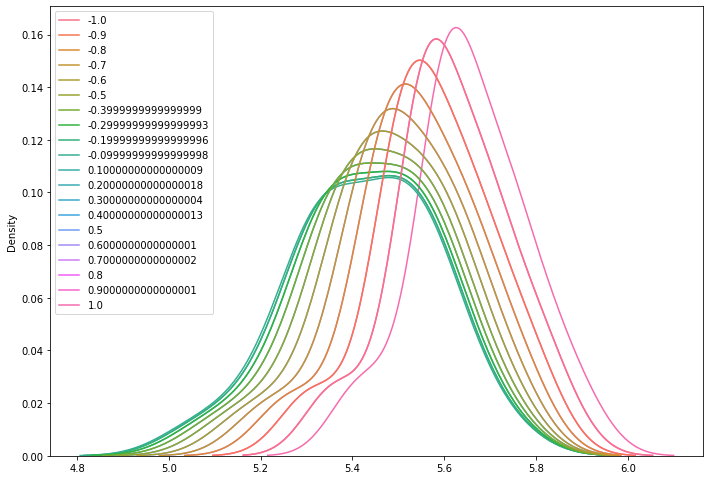

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.kdeplot(data = dat.astype(float));

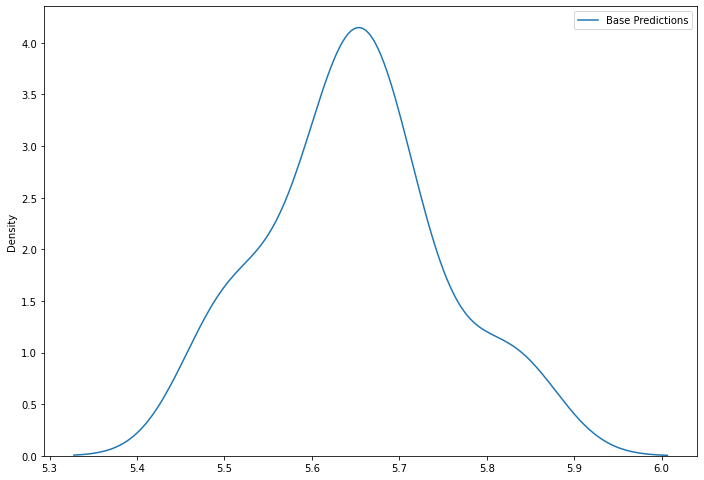

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.kdeplot(data = dat_base.astype(float));

In [ ]:
### Bootstrap Example ###

def prediction_interval(model, X_train, y_train, x0, alpha: float = 0.05):
  ''' Compute a prediction interval around the model's prediction of x0.

  INPUT
    model
      A predictive model with `fit` and `predict` methods
    X_train: numpy array of shape (n_samples, n_features)
      A numpy array containing the training input data
    y_train: numpy array of shape (n_samples,)
      A numpy array containing the training target data
    x0
      A new data point, of shape (n_features,)
    alpha: float = 0.05
      The prediction uncertainty

  OUTPUT
    A triple (`lower`, `pred`, `upper`) with `pred` being the prediction 
    of the model and `lower` and `upper` constituting the lower- and upper 
    bounds for the prediction interval around `pred`, respectively. '''

  # Number of training samples
  n = X_train.shape[0]

  # The authors choose the number of bootstrap samples as the square root 
  # of the number of samples
  nbootstraps = np.sqrt(n).astype(int)

  # Compute the m_i's and the validation residuals
  bootstrap_preds, val_residuals = np.empty(nbootstraps), []
  for b in range(nbootstraps):
    train_idxs = np.random.choice(range(n), size = n, replace = True)
    val_idxs = np.array([idx for idx in range(n) if idx not in train_idxs])
    model.fit(X_train[train_idxs, :], y_train[train_idxs])
    preds = model.predict(x_train[val_idxs])
    val_residuals.append(y_train[val_idxs] - preds)
    bootstrap_preds[b] = model.predict(x0)
  bootstrap_preds -= np.mean(bootstrap_preds)
  val_residuals = np.concatenate(val_residuals)

  # Compute the prediction and the training residuals
  model.fit(X_train, y_train)
  preds = model.predict(X_train)
  train_residuals = y_train - preds

  # Take percentiles of the training- and validation residuals to enable 
  # comparisons between them
  val_residuals = np.percentile(val_residuals, q = np.arange(100))
  train_residuals = np.percentile(train_residuals, q = np.arange(100))

  # Compute the .632+ bootstrap estimate for the sample noise and bias
  no_information_error = np.mean(np.abs(np.random.permutation(y_train) - \
    np.random.permutation(preds)))
  generalisation = np.abs(val_residuals - train_residuals)
  no_information_val = np.abs(no_information_error - train_residuals)
  relative_overfitting_rate = np.mean(generalisation / no_information_val)
  weight = .632 / (1 - .368 * relative_overfitting_rate)
  residuals = (1 - weight) * train_residuals + weight * val_residuals

  # Construct the C set and get the percentiles
  C = np.array([m + o for m in bootstrap_preds for o in residuals])
  qs = [100 * alpha / 2, 100 * (1 - alpha / 2)]
  percentiles = np.percentile(C, q = qs)
  
  return percentiles[0], model.predict(x0), percentiles[1]